In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylops

from scipy import linalg as la
from scipy import sparse

from .trips.io import build_x_true
from .trips.operators import gaussian_blur_operator, first_derivative_operator
from .trips.solvers.gks import GKSClass

ImportError: attempted relative import with no known parent package

### construct a true image

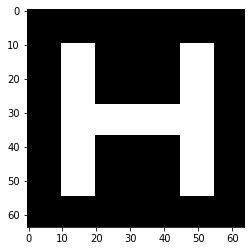

In [ ]:
x_true = build_x_true().reshape(-1,1)

plt.imshow(x_true.reshape(64,64), cmap='Greys_r')

### apply an operator

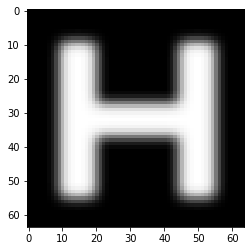

In [ ]:
blur_operator = gaussian_blur_operator([9,9],2,64,64)

b_true = blur_operator @ x_true

plt.imshow( b_true.reshape(64,64), cmap='Greys_r')

### contaminate with noise

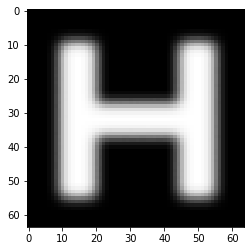

In [ ]:
noise_level = 0.001
noise = np.random.randn(64*64)
e = noise_level * np.linalg.norm(b_true) / np.linalg.norm(noise) * noise
e = e.reshape(-1,1)
b = b_true + e
plt.imshow( b.reshape(64,64), cmap='Greys_r')

### construct regularization operators

In [ ]:
I = pylops.Identity(4096) # identity operator
D = first_derivative_operator(n=4096) # first derivative operator
D2 = D @ D # second derivative operator

### run GKS with GCV

In [ ]:
solver = GKSClass(projection_dim=3, regparam='gcv', dp_stop=False, tol=10**(-16))
solver.run(blur_operator, b, D, iter=80, x_true=x_true)

running GKS...: 100%|██████████| 80/80 [00:16<00:00,  4.74it/s]


array([[-0.00605621],
       [-0.0150512 ],
       [ 0.00717515],
       ...,
       [-0.01081835],
       [-0.01572516],
       [-0.02197219]])

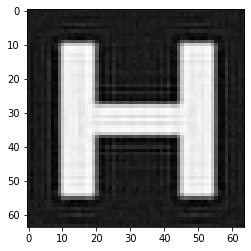

In [ ]:
plt.imshow(solver.x.reshape(64,64), cmap='Greys_r')

### Convergence

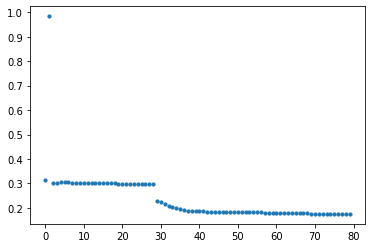

In [ ]:
plt.scatter(range(len(solver.rre_history)), solver.rre_history, s=10)

### history of solutions

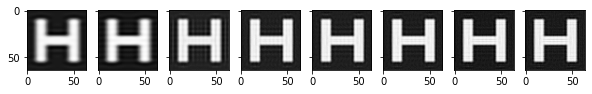

In [ ]:
fig, ax = plt.subplots(1, 8, figsize=(10, 10), sharey=True)

for ii in range(8):
    ax[ii].imshow(solver.x_history[9+10*ii].reshape(64,64), cmap='Greys_r')

plt.show()

### history of lambda values

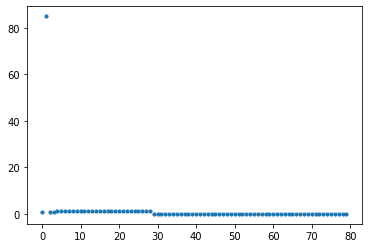

In [ ]:
plt.scatter(range(len(solver.lambda_history)), solver.lambda_history, s=10)

### run GKS with DP

In [ ]:
solver = GKSClass(projection_dim=3, regparam='dp', dp_stop=False, eta=1.01, delta=la.norm(e), tol=10**(-16))
solver.run(blur_operator, b, D, iter=80, x_true=x_true)

running GKS...:  38%|███▊      | 30/80 [00:00<00:01, 34.78it/s]c:\Users\conno\repos\multiparameter_package\trips\parameter_selection\discrepancy_principle.py:50: RuntimeWarning: divide by zero encountered in true_divide
  beta_new = beta - f/f_prime
c:\Users\conno\repos\multiparameter_package\trips\parameter_selection\discrepancy_principle.py:53: RuntimeWarning: invalid value encountered in subtract
  if abs(beta_new - beta) < 10**(-7)* beta:
running GKS...: 100%|██████████| 80/80 [00:05<00:00, 13.97it/s]


array([[-0.02104895],
       [-0.00232043],
       [ 0.03118373],
       ...,
       [-0.01269566],
       [ 0.0005655 ],
       [ 0.00305791]])

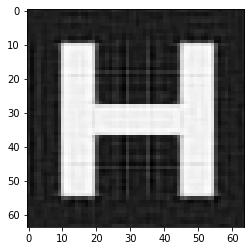

In [ ]:
plt.imshow(solver.x.reshape(64,64), cmap='Greys_r')

### convergence

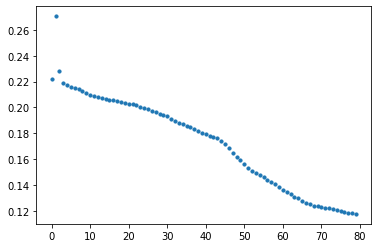

In [ ]:
plt.scatter(range(len(solver.rre_history)), solver.rre_history, s=10)

### history of solutions

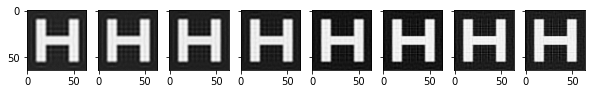

In [ ]:
fig, ax = plt.subplots(1, 8, figsize=(10, 10), sharey=True)

for ii in range(8):
    ax[ii].imshow(solver.x_history[9+10*ii].reshape(64,64), cmap='Greys_r')

plt.show()

### history of lambda values

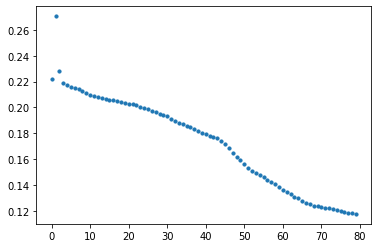

In [ ]:
plt.scatter(range(len(solver.rre_history)), solver.rre_history, s=10)

### run GKS with a sequence of parameter values

In [ ]:
regvals = [0.001*(0.5**(x)) for x in range(0,80)]

In [ ]:
solver = GKSClass(projection_dim=3, regparam=regvals, dp_stop=False, tol=10**(-16))
solver.run(blur_operator, b, D, iter=80, x_true=x_true)

running GKS...: 100%|██████████| 80/80 [00:03<00:00, 23.13it/s] 


array([[-0.01873864],
       [-0.00111126],
       [ 0.02966203],
       ...,
       [-0.0084036 ],
       [ 0.00189183],
       [ 0.00283511]])

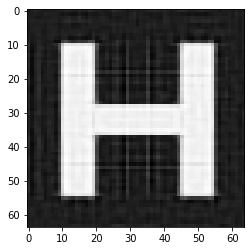

In [ ]:
plt.imshow(solver.x.reshape(64,64), cmap='Greys_r')

### convergence

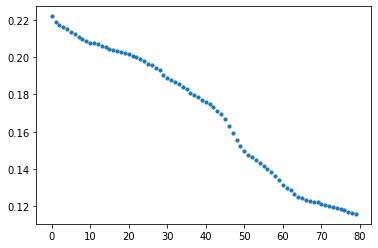

In [ ]:
plt.scatter(range(len(solver.rre_history)), solver.rre_history, s=10)

### history of solutions

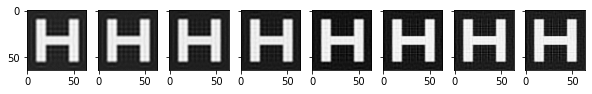

In [ ]:
fig, ax = plt.subplots(1, 8, figsize=(10, 10), sharey=True)

for ii in range(8):
    ax[ii].imshow(solver.x_history[9+10*ii].reshape(64,64), cmap='Greys_r')

plt.show()

### history of lambda values

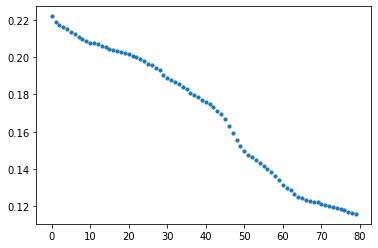

In [ ]:
plt.scatter(range(len(solver.rre_history)), solver.rre_history, s=10)

### run GKS with a sequence of parameter values, initialized by gcv

In [ ]:
# first, run several iterations with crossvalidation.
solver = GKSClass(projection_dim=3, regparam='gcv', dp_stop=False, tol=10**(-16))
solver.run(blur_operator, b, D, iter=10, x_true=x_true)

# then use the estimated to initialize a sequence of values.
regvals = [solver.lambda_history[-1]*(0.5**(x)) for x in range(0,80)]
solver.change_regparam(regvals)
solver.run(blur_operator, b, D, iter=80, x_true=x_true, warm_start=True)

running GKS...: 100%|██████████| 80/80 [00:04<00:00, 17.46it/s]


array([[-0.02112575],
       [-0.00445612],
       [ 0.03421515],
       ...,
       [-0.00238307],
       [-0.00087614],
       [-0.00867888]])

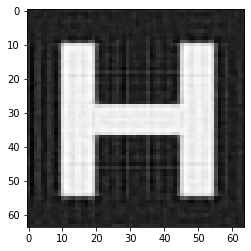

In [ ]:
plt.imshow(solver.x.reshape(64,64), cmap='Greys_r')

### convergence

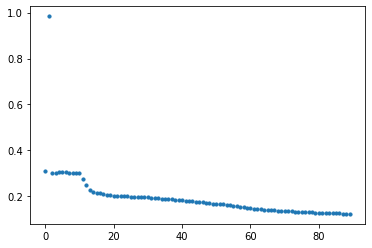

In [ ]:
plt.scatter(range(len(solver.rre_history)), solver.rre_history, s=10)

### history of solutions

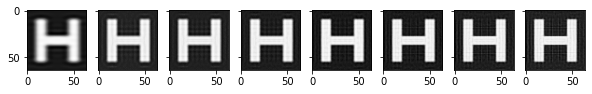

In [ ]:
fig, ax = plt.subplots(1, 8, figsize=(10, 10), sharey=True)

for ii in range(8):
    ax[ii].imshow(solver.x_history[10+10*ii].reshape(64,64), cmap='Greys_r')

plt.show()

### history of lambda values

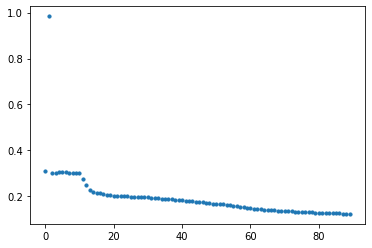

In [ ]:
plt.scatter(range(len(solver.rre_history)), solver.rre_history, s=10)